## House Prices Kaggle Competition

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [21]:
df = pd.read_csv('train.csv', index_col='Id')

## Data Analysis
* Need to optimize this step

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(f'Train Size: {len(df)} | Train Columns: {len(df.columns)}')

Train Size: 1460 | Train Columns: 80


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
(df.corr())["SalePrice"].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

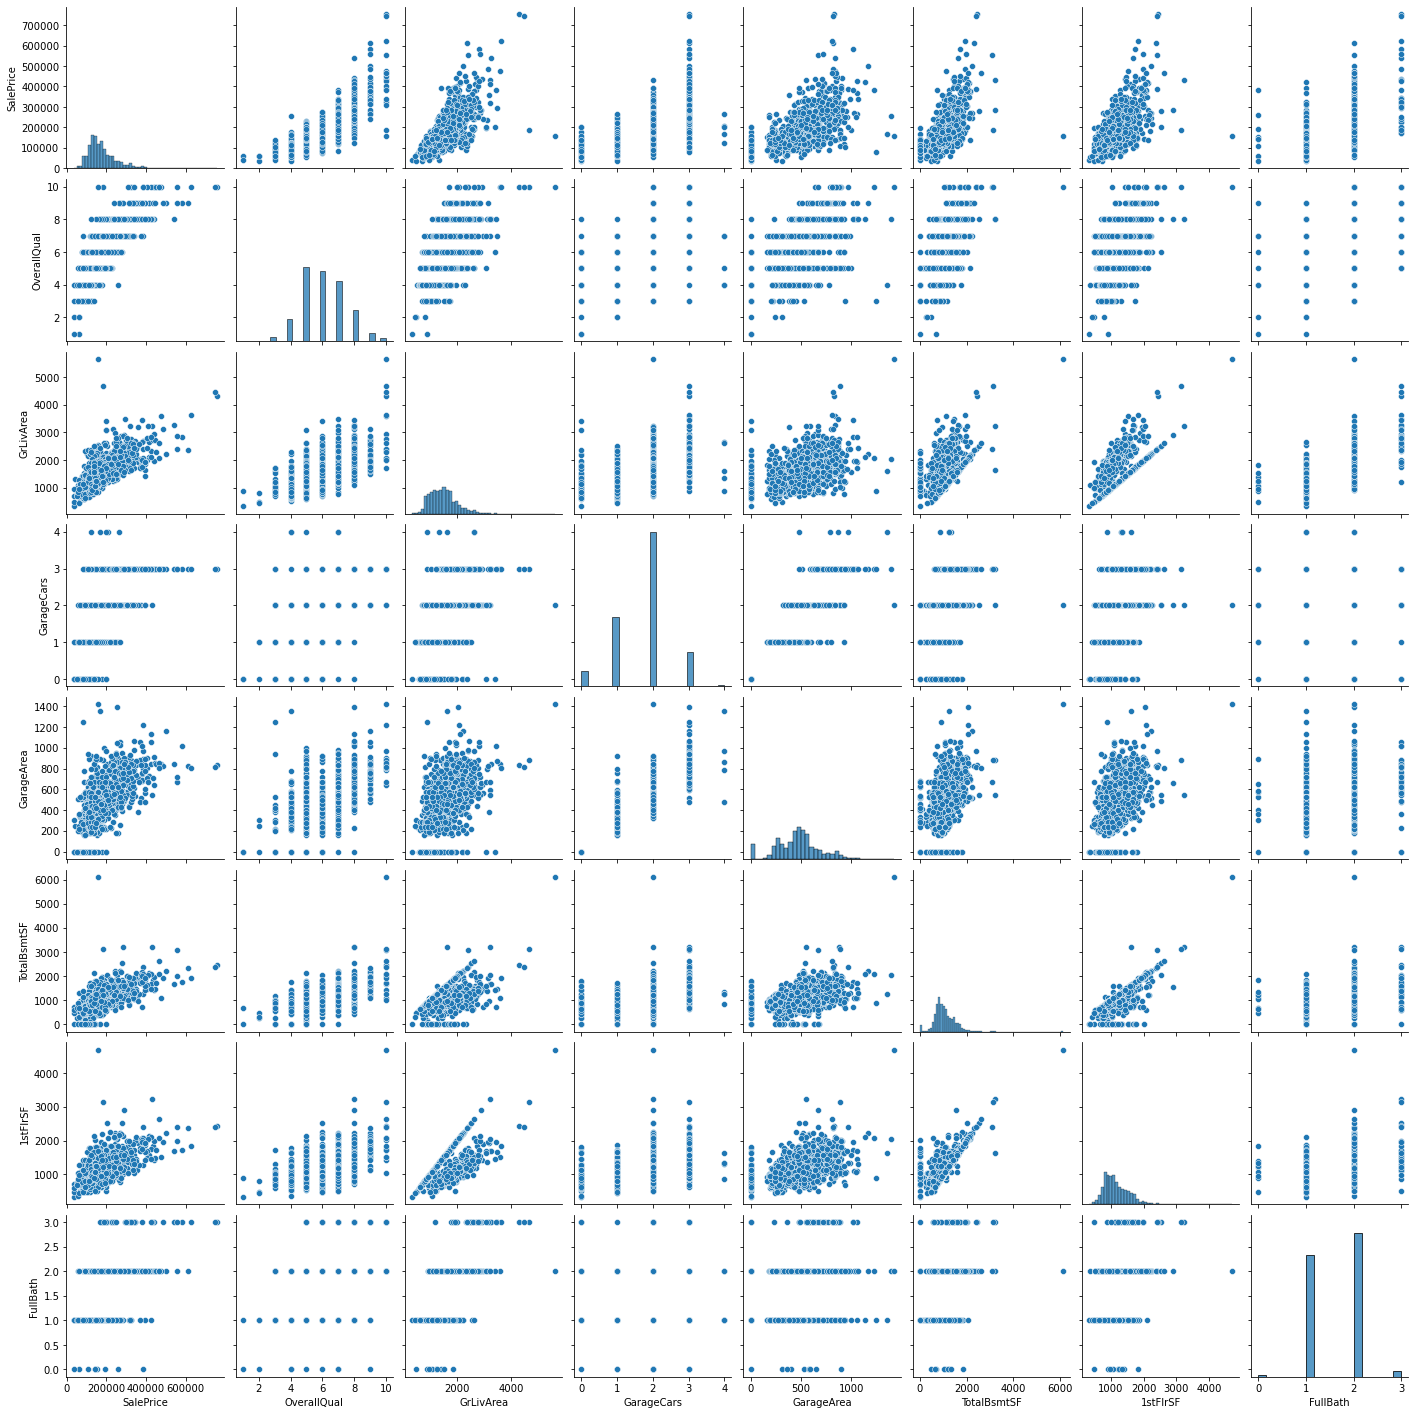

In [7]:
sns.pairplot(df[['SalePrice','OverallQual','GrLivArea','GarageCars',
                 'GarageArea','TotalBsmtSF','1stFlrSF','FullBath']])

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

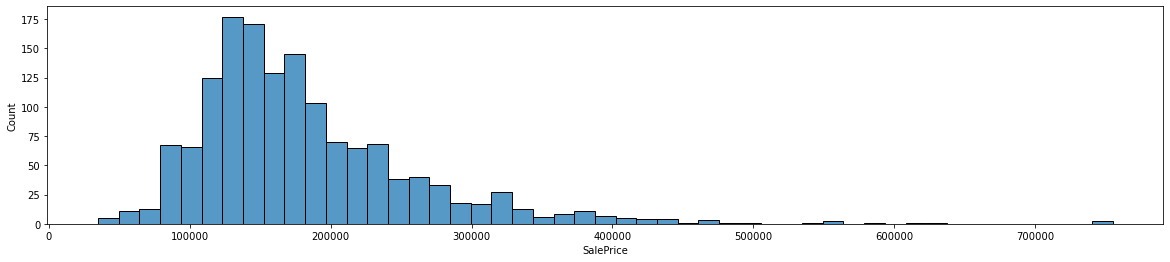

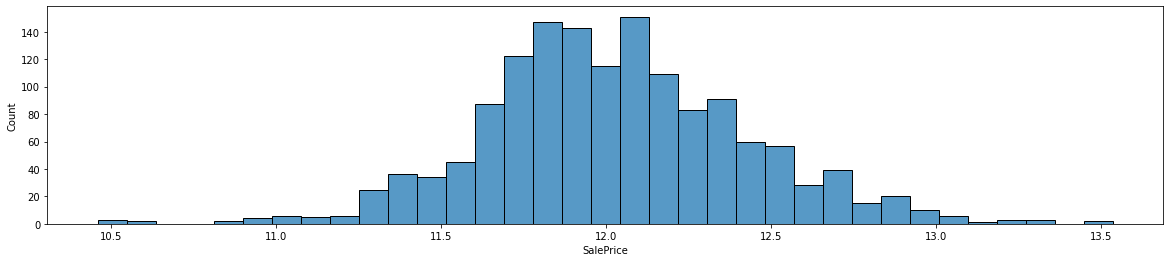

In [13]:
plt.figure(figsize=(20,4))
sns.histplot(df.SalePrice)
plt.figure(figsize=(20,4))
sns.histplot((np.log(df.SalePrice)))

## Preprocessing

In [22]:
df.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)
# many missing values

In [10]:
num_cols = [col for col in df if df[col].dtype != 'object' and col != 'SalePrice']
cat_cols = [col for col in df if df[col].dtype == 'object']

In [24]:
print(f'Total Cols = {len(df.columns)} | Numerical Cols: {len(num_cols)} | Categorical Cols: {len(cat_cols)}')

Total Cols = 75 | Numerical Cols: 36 | Categorical Cols: 38


In [25]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformer = ColumnTransformer([('numerical_pipeline', num_pipeline, num_cols),
                                 ('categorical_pipeline', cat_pipeline, cat_cols)])

* I won't do the split between train and test because I will use cross-validation, so I only perform the transformations in train data

In [26]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500


In [27]:
x_train, y_train = transformer.fit_transform(df.drop(['SalePrice'], axis=1)), np.log(df['SalePrice'])

## Modeling and Evaluating

In [29]:
params = {'n_neighbors':[3,5,7,9],
          'weights':['uniform', 'distance']}
knn = GridSearchCV(KNeighborsRegressor(), params)
knn.fit(x_train, y_train)
print(f'Best Parameters: {knn.best_params_}  Best Score: {knn.best_score_}')

Best Parameters: {'n_neighbors': 9, 'weights': 'distance'}  Best Score: 0.816591712591082


In [30]:
params = {'normalize':[True, False]}
lin_reg = GridSearchCV(LinearRegression(), params)
lin_reg.fit(x_train, y_train)
print(f'Best Parameters: {lin_reg.best_params_}  Best Score: {lin_reg.best_score_}')

Best Parameters: {'normalize': True}  Best Score: 0.8518988465750944


In [21]:
params = {'loss':[ 'squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive'],
          'penalty':['l2', 'l1', 'elasticnet']}
sgd_reg = GridSearchCV(SGDRegressor(), params)
sgd_reg.fit(x_train, y_train)
print(f'Best Parameters: {sgd_reg.best_params_}  Best Score: {sgd_reg.best_score_}')

Best Parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2'}  Best Score: 0.7874408734994464


In [22]:
params = {'n_estimators':[100,150,200]}
rf = GridSearchCV(RandomForestRegressor(), params)
rf.fit(x_train, y_train)
print(f'Best Parameters: {rf.best_params_}  Best Score: {rf.best_score_}')

Best Parameters: {'n_estimators': 150}  Best Score: 0.8732597473730142


In [31]:
params = {'kernel':['linear','poly','rbf','sigmoid'],
          'C':[1.0,0.95,0.9],
          'epsilon':[0.1,0.2]}
svr = GridSearchCV(SVR(), params)
svr.fit(x_train, y_train)
print(f'Best Parameters: {svr.best_params_}  Best Score: {svr.best_score_}')

Best Parameters: {'C': 0.9, 'epsilon': 0.1, 'kernel': 'poly'}  Best Score: 0.8773816777782244


## Submission

In [32]:
df_test = pd.read_csv('./test.csv', index_col='Id')
df_test.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)
data_for_submission = transformer.transform(df_test)

In [33]:
y_predicted = svr.predict(data_for_submission)

In [34]:
y_predicted = np.exp(y_predicted)

In [35]:
submission = pd.DataFrame({
    "Id": df_test.index,
    "SalePrice": y_predicted
})
submission.to_csv('submission.csv', index = False)